In [27]:
import os
from sklearn.feature_extraction.text import CountVectorizer

## Preprocess

In [28]:
os.listdir('tokens')

['neg', 'pos']

In [29]:
pos_path = os.path.join(os.getcwd(), 'tokens/pos')
neg_path = os.path.join(os.getcwd(), 'tokens/neg')
pos_files_list = os.listdir(pos_path)
neg_files_list = os.listdir(neg_path)
all_files_list = pos_files_list + neg_files_list

In [30]:
%%time
corpus = []
pos = []
neg = []
# prepare list with full path
for f in all_files_list:
    if f in pos_files_list:
        is_pos = True
        curr_path = pos_path
    else:
        is_pos = False
        curr_path = neg_path
    path = os.path.join(os.getcwd(), curr_path)
    path = os.path.join(path, f)
    corpus.append(path)
    if is_pos:
        pos.append(path)
    else:
        neg.append(path)

CPU times: user 19.2 ms, sys: 5.73 ms, total: 25 ms
Wall time: 19.9 ms


In [31]:
#sanity
print("Corpus size: %d" % len(corpus))
print("Pos size: %d" % len(pos))
print("Neg size: %d" % len(neg))

Corpus size: 1386
Pos size: 694
Neg size: 692


In [32]:
%%time
# extract corpus
vectorizer = CountVectorizer(input='filename', decode_error='ignore', binary=True, max_features=16165)
vectorizer.fit(corpus)
vect_pos = vectorizer.transform(pos)
vect_neg = vectorizer.transform(neg)
feature_mapping = vectorizer.get_feature_names()

CPU times: user 1.4 s, sys: 38.5 ms, total: 1.44 s
Wall time: 1.44 s


In [33]:
# sanity
print(vect_pos.shape)
print(vect_neg.shape)
print(len(feature_mapping))

(694, 16165)
(692, 16165)
16165


### Estimate example likelihoods

In [34]:
words_pos = ["love", "wonderful", "best", "great", "superb", "still", "beautiful"]
words_neg = ["bad", "worst", "stupid", "waste", "boring"]
words = words_pos + words_neg

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
doc_size = vect_pos.shape[0] + vect_neg.shape[0]
likelihoods = {w: (0,0) for w in words} #(pos,neg)
for w in words:
    idx = feature_mapping.index(w)
    pos_ll = np.sum(vect_pos[:,idx].todense()) / doc_size
    neg_ll = np.sum(vect_neg[:,idx].todense()) / doc_size
    likelihoods[w] = (pos_ll, neg_ll)

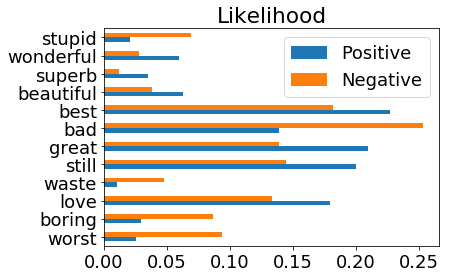

In [48]:
df = pd.DataFrame.from_dict(likelihoods, orient='index')
df = df.rename(columns={0: 'Positive', 1: 'Negative'})
plt.rcParams.update({'font.size': 18})
df.plot.barh(title="Likelihood")

# Reproduce results

In [14]:
import numpy as np
import scipy as sp

In [15]:
X = sp.sparse.vstack([vect_pos, vect_neg])
y = np.hstack([np.ones(vect_pos.shape[0]), np.zeros(vect_neg.shape[0])])

In [16]:
# sanity
print(X.shape)
print(y.shape)
print(y[692:695])

(1386, 16165)
(1386,)
[1. 1. 0.]


In [17]:
from sklearn.model_selection import KFold
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

In [18]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
kf.get_n_splits(X)

3

### No tuning applied

In [19]:
%%time
clfs = [BernoulliNB, LogisticRegression, LinearSVC]
names = ["NB", "MaxEnt", "SVM"]
for idx, clf_fn in enumerate(clfs):
    accs = []
    fold = 1
    print(names[idx])
    for train_idx, test_idx in kf.split(X):
        X_train, y_train = X[train_idx,:], y[train_idx]
        X_test, y_test = X[test_idx,:], y[test_idx]
        clf = clf_fn()
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        acc =  accuracy_score(y_test, y_pred)
        accs.append(acc)
        print("fold %d:" % fold, acc)
        fold += 1
    
    print("Avg: %lf\n" % np.mean(accs))

NB
fold 1: 0.7640692640692641
fold 2: 0.7489177489177489
fold 3: 0.8116883116883117
Avg: 0.774892

MaxEnt
fold 1: 0.8073593073593074
fold 2: 0.8181818181818182
fold 3: 0.8203463203463204
Avg: 0.815296

SVM
fold 1: 0.8051948051948052
fold 2: 0.8051948051948052
fold 3: 0.8095238095238095
Avg: 0.806638

CPU times: user 1.44 s, sys: 4.24 ms, total: 1.44 s
Wall time: 1.44 s


The results are comparable to the paper, though SVM could have some tuning.

Now let's try to improve, we'll train a 2-layer neural network with 100 neurons and relu activation function (default params).

## MLP

In [21]:
from sklearn.neural_network import MLPClassifier

In [21]:
%%time
clfs = [MLPClassifier]
names = ["MLP"]
for idx, clf_fn in enumerate(clfs):
    accs = []
    fold = 1
    print(names[idx])
    for train_idx, test_idx in kf.split(X):
        X_train, y_train = X[train_idx,:], y[train_idx]
        X_test, y_test = X[test_idx,:], y[test_idx]
        clf = clf_fn()
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        acc =  accuracy_score(y_test, y_pred)
        accs.append(acc)
        print("fold %d:" % fold, acc)
        fold += 1
    
    print("Avg: %lf\n" % np.mean(accs))

MLP
fold 1: 0.8246753246753247
fold 2: 0.8268398268398268
fold 3: 0.8311688311688312
Avg: 0.827561

CPU times: user 1min 13s, sys: 2min, total: 3min 13s
Wall time: 25.3 s


We aren't far from the best result reported in paper which was 82.9% for SVM on this setting.

Although we haven't applied all preprocessing steps as described in paper.

## Classifier comparison

Some plots for comparing the decision boundaries of our examined classifiers

3 datasets are used:
1. moons - makes two interleaving half circles
2. blobs - isotropic Gaussian blobs
3. linearly separable

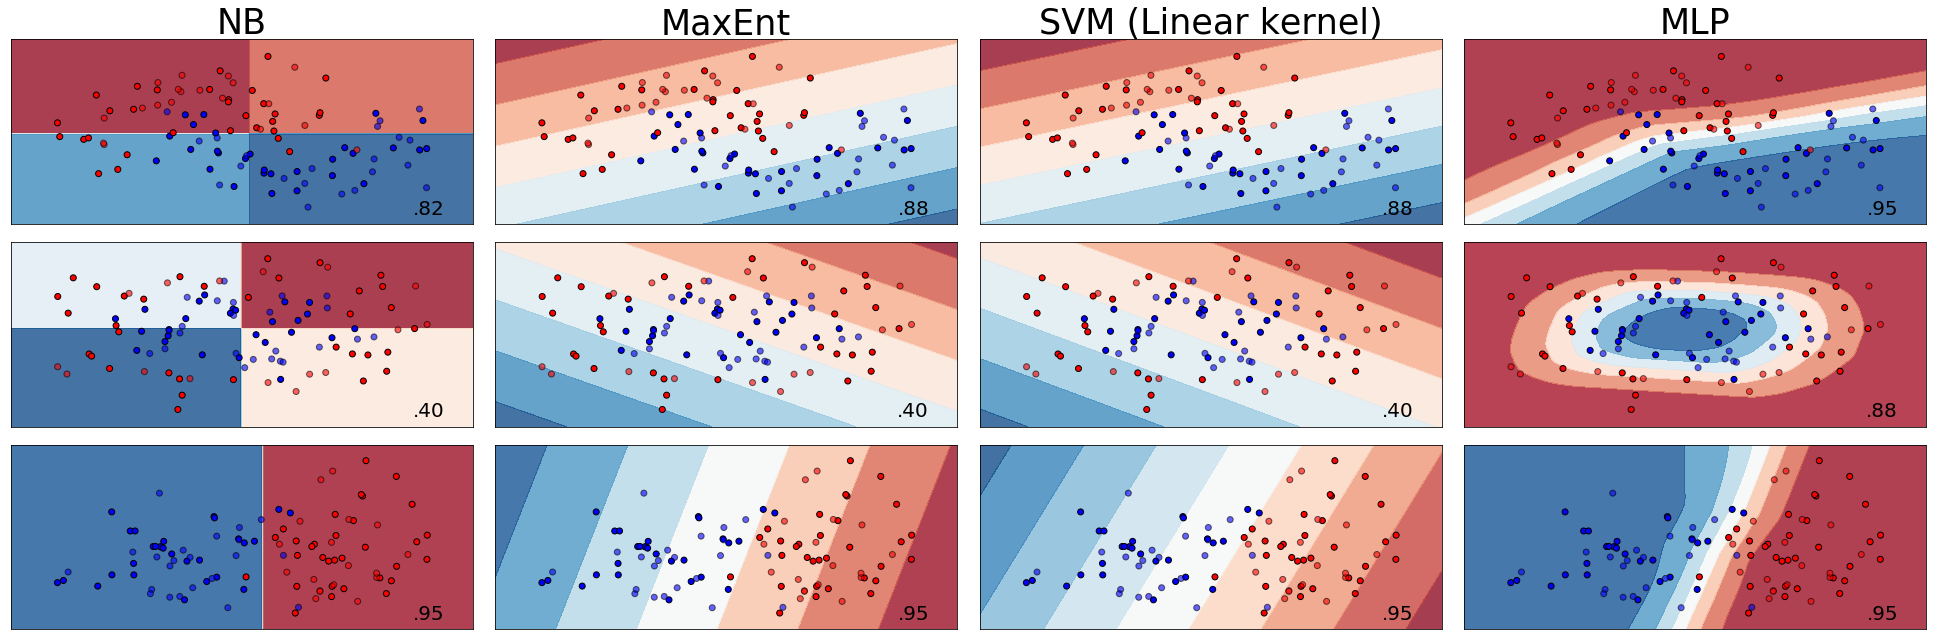

In [24]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification

h = .02  # step size in the mesh

names = ["NB", "MaxEnt", "SVM (Linear kernel)", "MLP"]

classifiers = [
    BernoulliNB(),
    LogisticRegression(),
    LinearSVC(),
    MLPClassifier()
]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers), i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        #ax.title
        if ds_cnt == 0:
            ax.set_title(name, size=35)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=20, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

Accuracy score is reported on bottom right corner.